# Cегментация держателей кредитных карт

В этом кейсе нам необходимо сегментировать клиентов банка на основе паттернов их поведения, содержащихся в датасете. Это позволит выбрать и провести грамотную маркетинговую кампанию для каждого сегмента по отдельности.

Так как в задании говорится о "сегментации" в сочетании с паттернами поведения - мы уже можем предположить, что нам предлагают решить задачу Обучения без учителя.

Подробное описание всех признаков можно найти на платформе Kaggle: https://www.kaggle.com/arjunbhasin2013/ccdata

Давайте для начала проведем EDA.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Загрузка данных

In [ ]:
df = pd.read_csv('./CC GENERAL.csv')

In [ ]:
df.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [ ]:
df.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8949.000000,8950.000000,8637.000000,8950.000000,8950.000000
mean,1564.474828,0.877271,1003.204834,592.437371,411.067645,978.871112,0.490351,0.202458,0.364437,0.135144,3.248827,14.709832,4494.449450,1733.143852,864.206542,0.153715,11.517318
std,2081.531879,0.236904,2136.634782,1659.887917,904.338115,2097.163877,0.401371,0.298336,0.397448,0.200121,6.824647,24.857649,3638.815725,2895.063757,2372.446607,0.292499,1.338331
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.019163,0.000000,6.000000
25%,128.281915,0.888889,39.635000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1600.000000,383.276166,169.123707,0.000000,12.000000
50%,873.385231,1.000000,361.280000,38.000000,89.000000,0.000000,0.500000,0.083333,0.166667,0.000000,0.000000,7.000000,3000.000000,856.901546,312.343947,0.000000,12.000000
75%,2054.140036,1.000000,1110.130000,577.405000,468.637500,1113.821139,0.916667,0.300000,0.750000,0.222222,4.000000,17.000000,6500.000000,1901.134317,825.485459,0.142857,12.000000
max,19043.138560,1.000000,49039.570000,40761.250000,22500.000000,47137.211760,1.000000,1.000000,1.000000,1.500000,123.000000,358.000000,30000.000000,50721.483360,76406.207520,1.000000,12.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

In [ ]:
df.isna().mean()*100

CUST_ID                             0.000000
BALANCE                             0.000000
BALANCE_FREQUENCY                   0.000000
PURCHASES                           0.000000
ONEOFF_PURCHASES                    0.000000
INSTALLMENTS_PURCHASES              0.000000
CASH_ADVANCE                        0.000000
PURCHASES_FREQUENCY                 0.000000
ONEOFF_PURCHASES_FREQUENCY          0.000000
PURCHASES_INSTALLMENTS_FREQUENCY    0.000000
CASH_ADVANCE_FREQUENCY              0.000000
CASH_ADVANCE_TRX                    0.000000
PURCHASES_TRX                       0.000000
CREDIT_LIMIT                        0.011173
PAYMENTS                            0.000000
MINIMUM_PAYMENTS                    3.497207
PRC_FULL_PAYMENT                    0.000000
TENURE                              0.000000
dtype: float64

Заметим, что у большинства признаков наблюдается следующая картина - их среднее гораздо больше их медианы. Соответственно можно сделать вывод, что в данных наблюдается некий "перекос" и нам нужно будет как-то его обработать.

Также, в некоторых признаках есть пропуск.

## EDA

Customer ID это просто ID клиента, для сегментации он нам не нужен, удалим его.

In [ ]:
df.drop(['CUST_ID'], axis=1, inplace=True)

Заметим, что у признака CREDIT_LIMIT всего 0.01% данных содержит пропуск. По сути это значит, что у нас всего одно наблюдение с пропуском в этом столбце - мы можем его просто выбросить и забыть об этом.

In [ ]:
df.dropna(subset=['CREDIT_LIMIT'], inplace=True)

Однако в MINIMUM_PAYMENTS пропусков достаточно много. К сожалению, в данных нет признака, который мог бы помочь нам заполнить пропуски в MINIMUM_PAYMENTS (смотрим на описание признака - на его "логику"). Если детально посмотреть на строки с пропусками, можно заметить, что пропуски в признаке плюс минус случайные (возможно оператор что-то забыл занести в базу данных). Для заполнения пропусков используем медиану (почему?).



Так как признак перекошенный, медиана лучший способ заполнить пропуски для сохранения основной тенденции признака.


In [ ]:
df['MINIMUM_PAYMENTS'].fillna(df['MINIMUM_PAYMENTS'].median(), inplace=True)

Давайте посмотрим, насколько наш датасет "перекошен".

Работаем только с числовыми признаками!

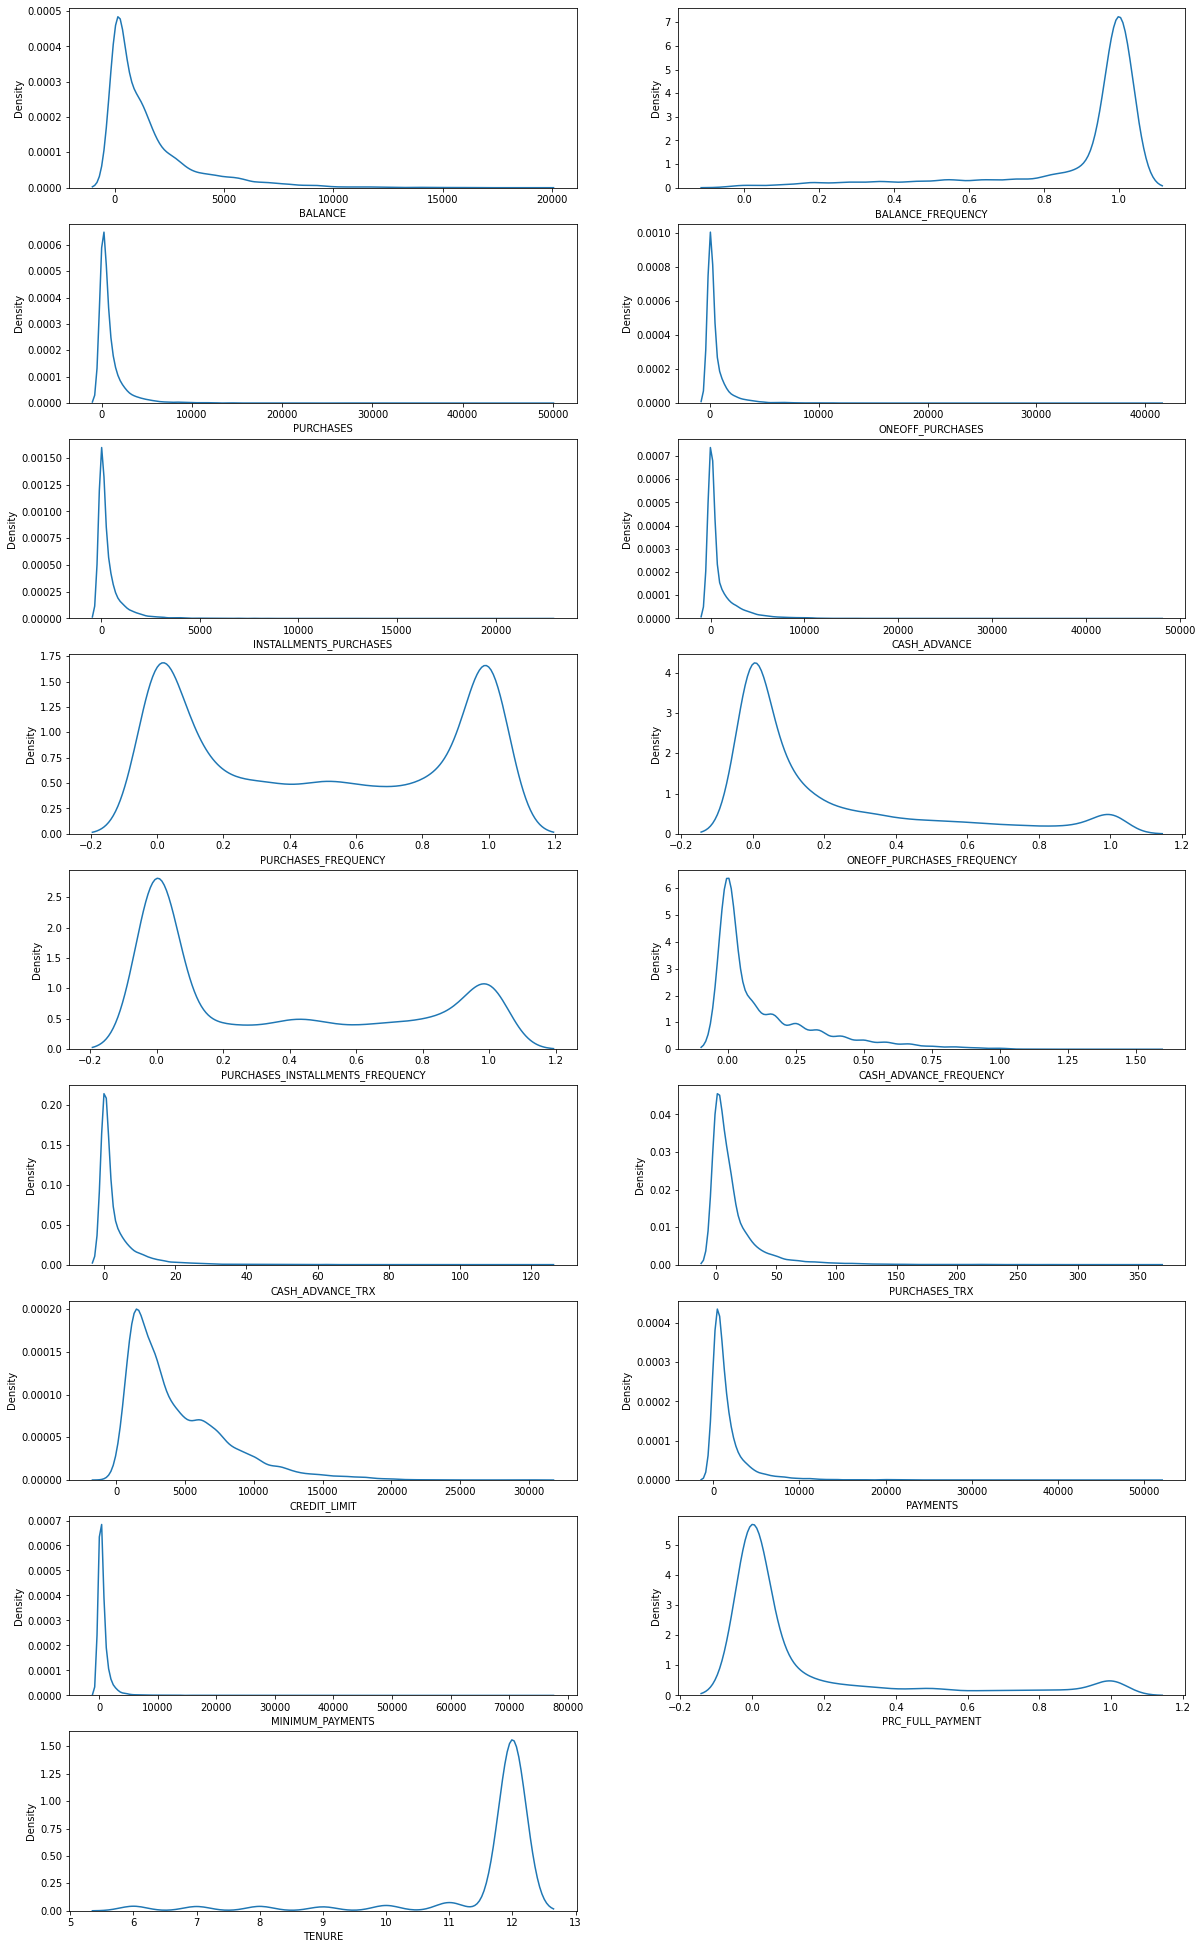

In [ ]:
plt.figure(figsize=(20,35))
for i, col in enumerate(df.columns):
    if df[col].dtype != 'object':
        ax = plt.subplot(9, 2, i+1)
        sns.kdeplot(df[col], ax=ax)
        plt.xlabel(col)
        
plt.show()

Итак, перекосов много, и они разные. В целом для подобных задач это нормально, поскольку всегда будут клиенты, которые будут сильно выделяться из общей массы (например, будут совершать огромное количество транзакций.

Давайте попробуем с этим побороться (как? зачем?).





**Как**: добавим единицу, чтобы не попасть в случай log(0) = бесконечность, и прологарифмируем

**Зачем**: чтобы наша модель, смогла лучше отработать (сформировать адекватные кластеры)

In [ ]:
cols = ['BALANCE', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'ONEOFF_PURCHASES_FREQUENCY','PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT']

In [ ]:
for col in cols:
    df[col] = np.log(1 + df[col])

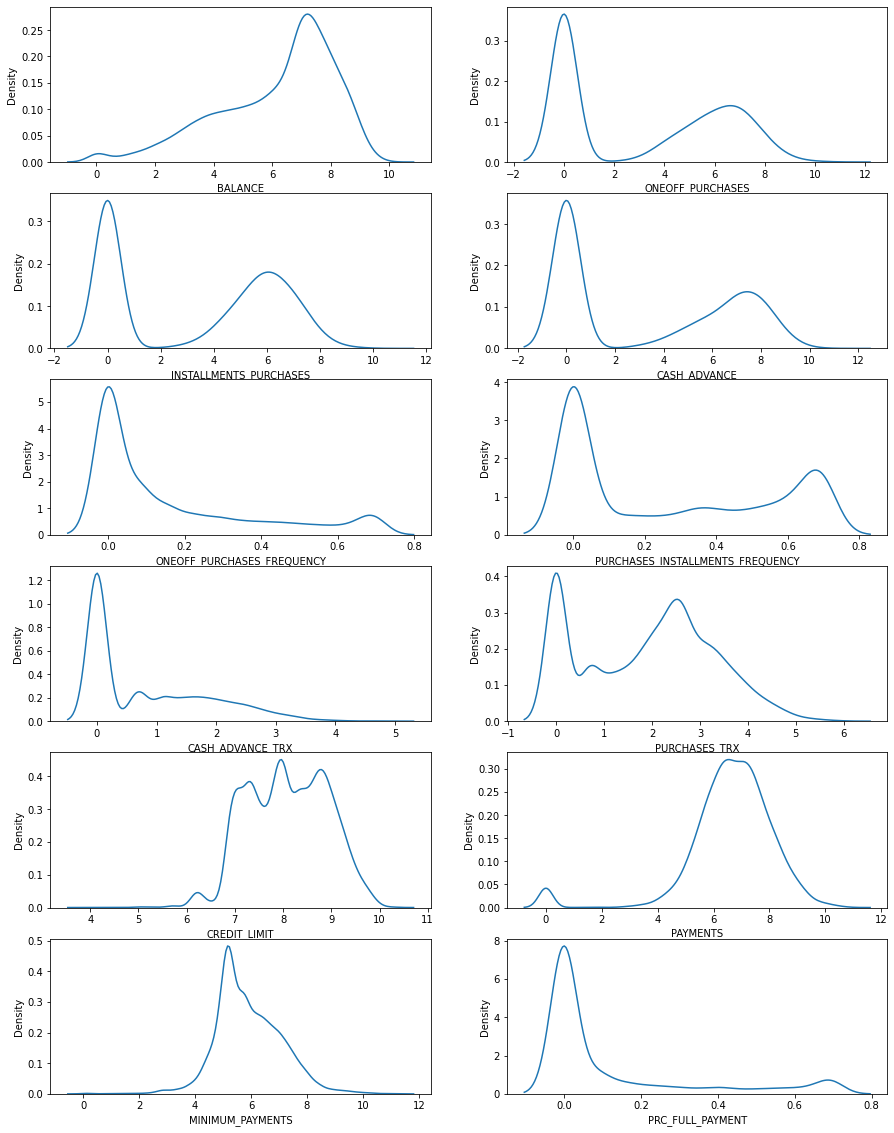

In [ ]:
plt.figure(figsize=(15,20))
for i, col in enumerate(cols):
    ax = plt.subplot(6, 2, i+1)
    sns.kdeplot(df[col], ax=ax)
plt.show()

Понятное дело, что такие распределения все равно не идеальные, но ситуация улучшилась.

Наша задача как DS - максимально помочь нашей модели хорошо обучиться.

Далее посмотрим на корреляционную матрицу.

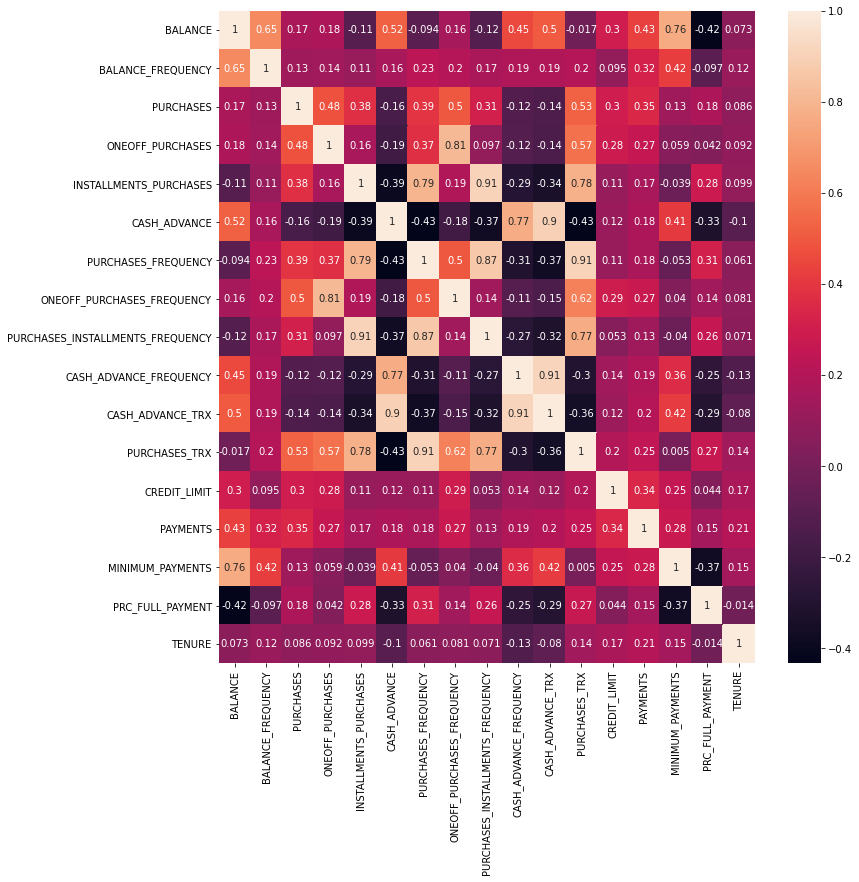

In [ ]:
plt.figure(figsize=(12,12))
sns.heatmap(df.corr(), annot=True)
plt.show()

Итак в данных есть признаки, которые коррелируют между собой. Почему это плохо?



**Сильно коррелированные переменные**

Сильно коррелированные друг с другом переменные дают модели одну и ту же информацию, следовательно, для анализа не нужно использовать их все. Например, если набор данных (dataset) содержит признаки «Время в сети» и «Использованный трафик», можно предположить, что они будут в некоторой степени коррелированы, и мы увидим сильную корреляцию, даже если выберем непредвзятый образец данных. В таком случае в модели нужна только одна из этих переменных. Если использовать обе, то модель окажется переобучена (overfit) и предвзята относительно одного отдельного признака.


Давайте используем PCA (Метод главных компонент) и понизим размерность наших данных, чтобы с этим побороться.

Больше о PCA можно почитать здесь - http://www.machinelearning.ru/wiki/index.php?title=Метод_главных_компонент


Зададим количество компонент так, чтобы наши данные в меньшей размерности давали нам 95% разнообразие наших исходных данных. 

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
X_red = pca.fit_transform(df)

Итак, мы готовы обучаться, в качестве алгоритма, давайте используем самый простой алгоритм кластеризации - K-Means.

## Обучение

Сегодня мы узнали, как работает алгоритм K-Means, поэтому давайте подумаем, с какими сложностями мы можем столкнуться при обучении.

Как мы помним из теоретической части итоговый результат очень зависит от изначального выбора центроидов. 

Давайте используем два трюка, чтобы справится с этим.

Во-первых, давайте просто запустим алгоритм несколько раз (каждый раз центроиды будут инициализироваться случайным образом), меняя при этом количество кластеров, которые необходимо выделить алгоритму. 

Чтобы определить, какая из получившихся моделей работает лучше всего, мы используем "инерцию" модели или WCSS (Within Cluster Summation of Squares). Это один из внутренних методов оценки качества - сумма квадратов расстояний от объектов кластера до центра этого кластера.

Во-вторых, давайте используем вариацию алгоритма K-Means, а именно K-Means++. Этот алгоритм инициализирует центроиды так, чтобы они были как можно дальше друг от друга. 

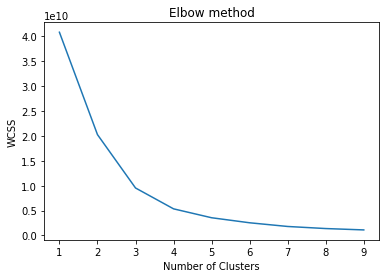

In [ ]:
from sklearn.cluster import KMeans

kmeans_models = [KMeans(n_clusters=k, init='k-means++',random_state=23).fit(X_red) for k in range (1, 10)]
innertia = [model.inertia_ for model in kmeans_models]

plt.plot(range(1, 10), innertia)
plt.title('Elbow method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

Подобный подход к визуализации в задачах кластеризации называется методом локтя (elbow method). Кажется, что "локоть" находится в точке 3 или 4 по оси X. 

Давайте посмотрим в какой точке алгоритм отрабатывает лучше, используя коэффициент силуэта.

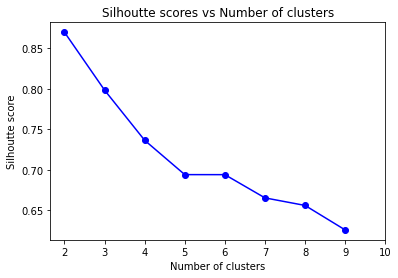

In [ ]:
from sklearn.metrics import silhouette_score

silhoutte_scores = [silhouette_score(X_red, model.labels_) for model in kmeans_models[1:]]
plt.plot(range(2,10), silhoutte_scores, "bo-")
plt.xticks([2, 3, 4,5,6,7,8,9,10])
plt.title('Silhoutte scores vs Number of clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Silhoutte score')
plt.show()

Оказывается, что лучший коэффициент силуэта все же у точки 2. Поэтому предположим, что в наших данных два кластера.

## Тестирование и inference

In [ ]:
from sklearn.metrics import silhouette_score

kmeans = KMeans(n_clusters=2, random_state=23)
kmeans.fit(X_red)

print('Silhoutte score of our model is ' + str(silhouette_score(X_red, kmeans.labels_)))

Silhoutte score of our model is 0.8700455999561516


Давайте добавим в наш датасет столбец cluster_id, в котором будут значения кластеров, предсказанные K-Means для каждого наблюдения

In [ ]:
df['cluster_id'] = kmeans.labels_

Проведем обратную трансформацию (если помните во время EDA мы прологарифмировали данные), чтобы сделать грамотную визуализацию.

In [ ]:
for col in cols:
    df[col] = np.exp(df[col])

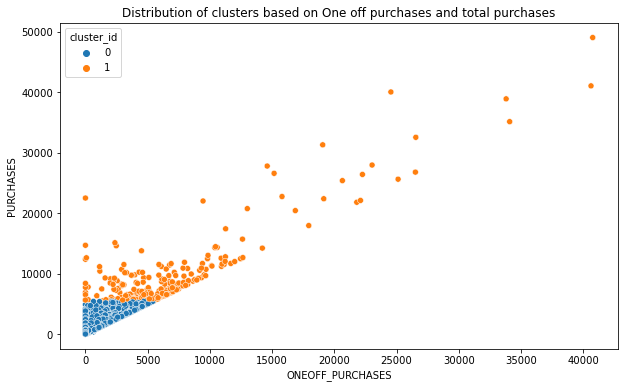

In [ ]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='ONEOFF_PURCHASES', y='PURCHASES', hue='cluster_id')
plt.title('Distribution of clusters based on One off purchases and total purchases')
plt.show()

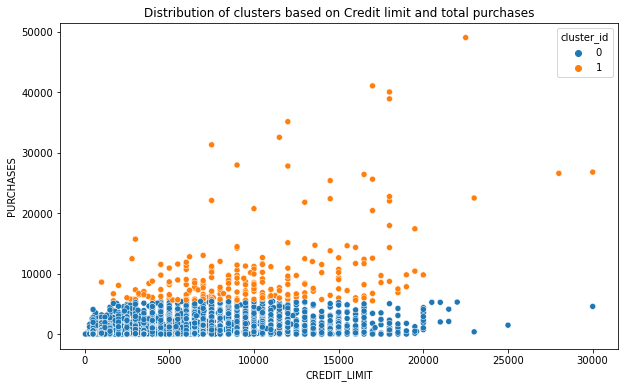

In [ ]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='CREDIT_LIMIT', y='PURCHASES', hue='cluster_id')
plt.title('Distribution of clusters based on Credit limit and total purchases')
plt.show()

Судя по всему наша модель разделила всех клиентов на два кластера: в один попали люди с низким уровнем использования кредитной карты, а в другой - с высоким. 

Отлично, нам удалось построить грамотную сегментацию.


### Extra

Тем не менее, на графике "локтем" все же является точка 3. Давайте посмотрим, какие кластеры у нас получатся, если взять 3 в качестве количества кластеров.

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=23)
kmeans.fit(X_red)

KMeans(n_clusters=3, random_state=23)

In [ ]:
df['cluster_id'] = kmeans.labels_

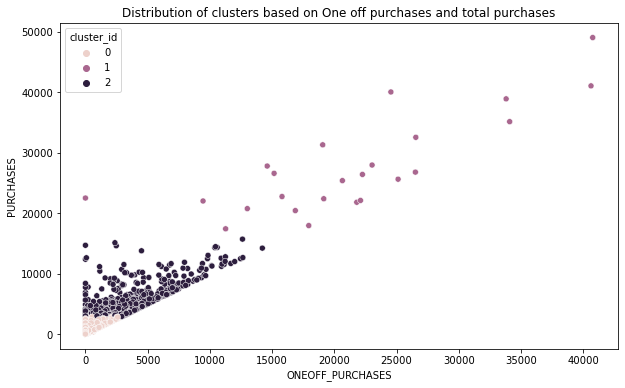

In [ ]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='ONEOFF_PURCHASES', y='PURCHASES', hue='cluster_id')
plt.title('Distribution of clusters based on One off purchases and total purchases')
plt.show()

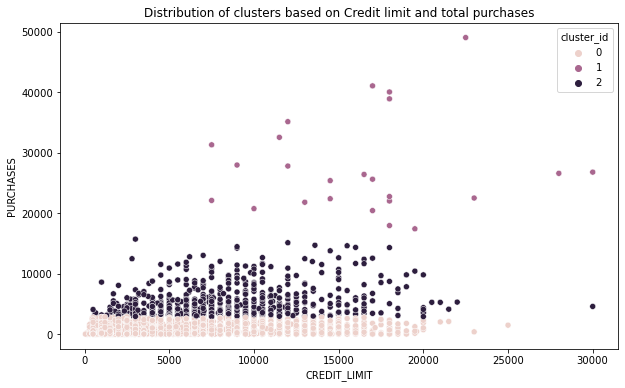

In [ ]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='CREDIT_LIMIT', y='PURCHASES', hue='cluster_id')
plt.title('Distribution of clusters based on Credit limit and total purchases')
plt.show()

С моей точки зрения такая кластеризация гораздо лучше той, что мы построили выше, потому что в данном случае у нас получились три четких сегмента:

- Люди, которые мало используют кредитные карты
- Люди - "середнячки"
- Люди, которые используют их очень много

Подобный результат кажется гораздо более осмысленным с точки зрения бизнеса.

## SUMMARY

Задача кластеризации с первого взгляда может показаться очень сложной и неочевидной. Не беспокойтесь, так кажется всем Data Scientists, которые только начинают знакомиться с Обучением без учителя.

Тем не менее, стоит отметить, что направление Обучения без учителя в Machine Learning сейчас не сильно развивается и используется. Однако это не делает задачу и алгоритмы кластеризации какими-то "не такими". Просто индустрия сейчас идет в другом направлении. А хорошему DS важно знать все возможности, которые есть в индустрии. Кто знает, возможно именно вы придумаете какой-то новый подход к работе с задачей кластеризации, который сделает ее более популярной, чем задача классификации.

Стоит отметить, что в Deep Learning направление Обучения без учителя намного более актуальное. Есть целый раздел, который называется Reinforcement Learning, занимающийся изучением и применением Обучения без учителя.